# Linear Modeling

### Introduction 

This notebook contains some linear modelling performed on the data downloaded from [UCI machine learning repository](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions)

We will be using the train/test data provided in order to use linear classification models to identify which activity is being performed based off of phone sensor data.

First, we'll start off by importing our required libraries for this analysis

In [4]:
# importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importing automation libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# importing dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# importing models
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

The way this data is read is explained in `01 Basic_EDA.ipynb` 

In [5]:
# reading in the data
columns = pd.read_csv('data/features2.txt', header = None)

X_train = pd.read_csv('data/Train/X_train.txt', names = columns[0], sep=' ')
X_test = pd.read_csv('data/Test/X_test.txt', names = columns[0], sep=' ')

y_train = pd.read_csv('data/Train/y_train.txt', sep=' ', header = None)
y_test = pd.read_csv('data/Test/y_test.txt', sep=' ', header = None)

In [6]:
X = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])

### Plan

For the sake of time and efficiency, we'll try a quick pipeline with dimensionality reduction and some linear models to find the best performing model.

We'll make use of the method `gridsearchCV` to iterate through different models quickly, perform some hyperparameter optimization and cross validation all at the same time.

### Pipeline

We start off by setting up our estimators and running them through the pipe. Then. with the parameter grid, we throw it into GridSearchCV to iterate through all possible combinations to find the model with the best score.

In our grid, we'll be using the following models and dimensionality reduction techniques:

**Models**
- Support Vector Machine
- Decision Tree Classifier
- Logistic Regression
- K-Nearest Neighbors

**Dimensionality Reduction**
- t-SNE
- Principal Component Analysis

We'll also be using a cross validation split of 5.

In [7]:
estimators = [
    ('dim_reduction', PCA()),
    ('model', svm.SVC())
]
pipe = Pipeline(estimators)

param_grid = [
            {
                'dim_reduction': [TSNE(),PCA()],
                'dim_reduction__n_components': [3, 5, 10],
                'model': [DecisionTreeClassifier()], 
                'model__max_depth': range(1, 10),
            },
            {
                'dim_reduction': [TSNE(),PCA()],
                'dim_reduction__n_components': [3, 5, 10],
                'model': [LogisticRegression()], 
                'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
            },
             {
                'dim_reduction': [None],
                'model': [KNeighborsClassifier()], 
                'model__n_neighbors': range(1, 40, 2),
            }
] 

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)

fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


In [8]:
fittedgrid.best_estimator_

Pipeline(steps=[('dim_reduction', None),
                ('model', KNeighborsClassifier(n_neighbors=9))])

Interesting! It seems like the best combination came out to be no dimensionality reduction with K-Nearest Neighbors being the best classifier to use, with 9 n_neighbors. I would have thought that having some dimensionality reduction would have given better results, but that wasn't the case.

We can also take a look at how well each combination scored and how well our best estimator scored using the `.cv_results_` and .score methods respectively. 

In [9]:
# all the 110 mean CV scores for the different param combinations
fittedgrid.cv_results_['mean_test_score']

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.34067206, 0.59070558, 0.69383516,
       0.69177678, 0.71134683, 0.71778515, 0.71070415, 0.71855627,
       0.71121655, 0.34067206, 0.59070558, 0.70709268, 0.70387716,
       0.72010067, 0.73812897, 0.75126061, 0.74276408, 0.74173506,
       0.34067206, 0.59585359, 0.71340338, 0.73297359, 0.75665922,
       0.76593574, 0.76541944, 0.76670785, 0.76529389,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.71018364, 0.74816758, 0.76104

In [10]:
# final reported performance of the best estimator
fittedgrid.score(X_test, y_test)

0.8889943074003795

Although our model scored 88.899%, we can see that there were a few numbers that scored within 1% of this, so there could be other combinations that worked almost just as well, but are more efficient, but so far, I'm pretty happy with this model.

Let's continue to do some more model evaluation on our best estimator!

---

### Model Evaluation

For our model evaluation, we will take a look at the confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix

y_pred = fittedgrid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[486   1   9   0   0   0   0   0   0   0   0   0]
 [ 37 430   4   0   0   0   0   0   0   0   0   0]
 [ 49  46 325   0   0   0   0   0   0   0   0   0]
 [  0   4   0 406  98   0   0   0   0   0   0   0]
 [  0   2   0  38 516   0   0   0   0   0   0   0]
 [  0   1   0   2   2 540   0   0   0   0   0   0]
 [  1   4   0   1   0   0  17   0   0   0   0   0]
 [  0   0   0   0   0   0   0  10   0   0   0   0]
 [  0   0   0   0   0   0   0   0  28   0   4   0]
 [  0   0   0   0   0   0   0   0   1  21   0   3]
 [  2   5   0   0   1   0   4   0  16   0  21   0]
 [  1   0   0   0   0   0   0   0   1  12   2  11]]


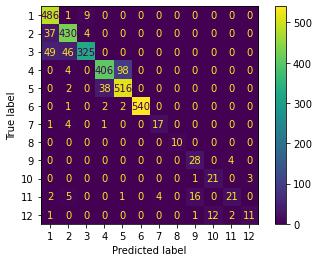

In [14]:
from sklearn.metrics import plot_confusion_matrix
# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(fittedgrid, X_test, y_test);

From the confusion matrix above, we can see that the most commonly misclassified classes were
4: misclassified as 5, 98 times
3: misclassified as 2, 46 times
1: misclassified as 3 and 2, 49 and 37 times respectively

Other than these misclassifications, we can see that there are few others misclassified.

We can also see high numbers of classification for classes 1 to 6, this makes sense as these are the main actions. Classes 7 to 12 are the actions in between static movements.